# Sentiment Analysis of Clothes Reviews

Description: main idea, methods, results
I am going to analyze which Machine Learning Algorithm suits best for the prediction of sentiment when we deal with a comparatively small data set. In this notebook I performed a sentiment analysis of Clothes Reviews using Basic Algorithms such as Naive Bayes, Dense and Recurrent Neural Networks using Keras in Tensorflow. The highest accuracy achieved is 95%.


### Import packages and libraries


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as pex
from wordcloud import WordCloud
from datetime import datetime 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from keras import callbacks

### Read and Explore Data

First, we read the dataframe from csv format and look at it.

In [2]:
df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


We see that there is unnecessary column 'Unnamed: 0'. We need to delete it.

In [3]:
del df['Unnamed: 0']
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


There is a table with 23486 records and 10 features per record. In this dataframe there are different characteristics of customers' reviews. Firstly, we need to perform EDA (Exploratory Data Analysis).

Let's look at missing values.

In [4]:
df.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Some columns have missing values, but we need only Review Text and Rating for the predictions, so we can clean missing values only in these columns. After dropping NA values, we also need to reset index.

In [5]:
df = df.dropna(subset = ['Review Text'])
df = df.reset_index(drop = True)
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
22636,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
22637,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
22638,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
22639,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


As we need only two columns to perform prediction, we will explore them. To do so, we need to look at the distribution of ratings to see if there is any imbalance.

In [6]:
fig = pex.histogram(df, x='Rating')
fig.show()

As we can see, there is a huge imbalance between positive and negative reviews. To overcome it, we need to control for precision, recall, and AUC during and after training.

To look at the popular words in reviews, we will construct the wordcloud.

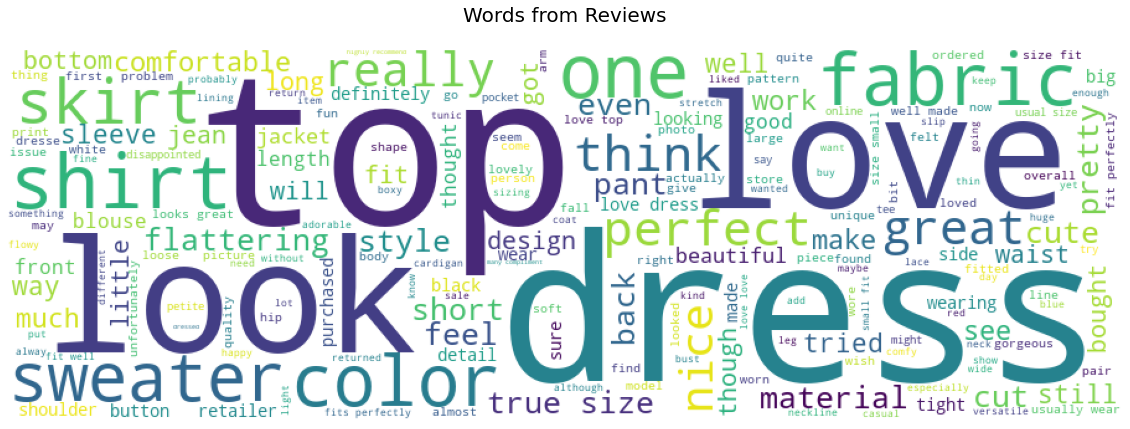

In [7]:
#Data visualization
rev = df['Review Text']

plt.subplots(figsize=(20,12))
wordcloud = WordCloud(background_color='white', width=900, height=300).generate(" ".join(rev))
plt.imshow(wordcloud)
plt.title('Words from Reviews\n',size=20)
plt.axis('off')
plt.show()

### Prepare Data for Prediction

For simplicity we will extract needed columns from the original dataframe into a new one.

In [8]:
df1 = df[['Review Text', 'Rating']]
df1

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
22636,I was very happy to snag this dress at such a ...,5
22637,"It reminds me of maternity clothes. soft, stre...",3
22638,"This fit well, but the top was very see throug...",3
22639,I bought this dress for a wedding i have this ...,3


First, we need to prepare data for binary classification. As we do not need neutral reviews (with Rating 3), we create a new dataframe without them.

In [9]:
df_binary = df1[df1['Rating'] != 3]
df_binary = df_binary.reset_index(drop = True)
df_binary

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,"I love, love, love this jumpsuit. it's fun, fl...",5
3,This shirt is very flattering to all due to th...,5
4,"I love tracy reese dresses, but this one is no...",2
...,...,...
19813,I'm so impressed with the beautiful color comb...,4
19814,I was surprised at the positive reviews for th...,1
19815,So i wasn't sure about ordering this skirt bec...,5
19816,I was very happy to snag this dress at such a ...,5


Now, we need to create a new column with the sentiment (0 for negative sentiment, and 1 for positive sentiment) with the consideration that 1,2 reviews are negative, while 4,5 reviews are positive.

In [10]:
for i in range(len(df_binary)):
  rating = df_binary.loc[i,'Rating']
  if rating >= 4:
    sentiment = 1
  elif rating <= 2:
    sentiment = 0
  df_binary.loc[i, 'Class'] = sentiment
df_binary

,Review Text,Rating,Class
0,Absolutely wonderful - silky and sexy and comf...,4,1.0
1,Love this dress! it's sooo pretty. i happene...,5,1.0
2,"I love, love, love this jumpsuit. it's fun, fl...",5,1.0
3,This shirt is very flattering to all due to th...,5,1.0
4,"I love tracy reese dresses, but this one is no...",2,0.0
...,...,...,...
19813,I'm so impressed with the beautiful color comb...,4,1.0
19814,I was surprised at the positive reviews for th...,1,0.0
19815,So i wasn't sure about ordering this skirt bec...,5,1.0
19816,I was very happy to snag this dress at such a ...,5,1.0


Also, for a multiclass classification we need to create a dataframe with three classes (0 for negative sentiment, and 1 for neutral sentiment, and 2 for positive sentiment).

In [11]:
for i in range(len(df1)):
  rating = df1.loc[i,'Rating']
  if rating >= 4:
    sentiment = 2
  elif rating <= 2:
    sentiment = 0
  elif rating == 3:
    sentiment = 1
  df1.loc[i, 'Class'] = sentiment
df1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Review Text,Rating,Class
0,Absolutely wonderful - silky and sexy and comf...,4,2.0
1,Love this dress! it's sooo pretty. i happene...,5,2.0
2,I had such high hopes for this dress and reall...,3,1.0
3,"I love, love, love this jumpsuit. it's fun, fl...",5,2.0
4,This shirt is very flattering to all due to th...,5,2.0
...,...,...,...
22636,I was very happy to snag this dress at such a ...,5,2.0
22637,"It reminds me of maternity clothes. soft, stre...",3,1.0
22638,"This fit well, but the top was very see throug...",3,1.0
22639,I bought this dress for a wedding i have this ...,3,1.0


## 1st Problem: Binary Classification

### Naive Bayes


#### Data Preparation

To store the review sequences for basic ML algorithm, we will use TFidfVectorizer.

In [42]:
vectorizer = TfidfVectorizer()

We create X (features) and Y (class) vectors to feed the vectorizer.

In [43]:
X = df_binary['Review Text'].values
Y = df_binary['Class'].values

Now, we divide the data into test and train datasets. We use 20% of the data as test. We use random state parameter to make the work reproducible.

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1145)


Now,  we can train the vectorizer on the train data and transorm both train and test data into Tfidf matrix.

In [45]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### Model creation and analysis

We create and train Naive Bayes model to predict sentiment.

In [46]:
#First we use Naive Bayes model which allegedly works quickly 
model = MultinomialNB()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

To look at the performance of the model, we can use classification report function.

In [47]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       493
         1.0       0.88      1.00      0.93      3471

    accuracy                           0.88      3964
   macro avg       0.94      0.50      0.47      3964
weighted avg       0.89      0.88      0.82      3964



The recall is extremely bad, so the model is inaccurate. 

### Neural Networks

#### Data Preparation

Create two vectors for X (features) and for Y (labels) which is a convention among data scientists. Add *.values* at the end of the declaration to transform the dataframe or series into a numpy array.

In [18]:
X = df_binary['Review Text'].values
Y = df_binary['Class'].values

Now, we divide the data into test and train datasets. We use 20% of the data as test. We use random state parameter to make the work reproducible.

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1145)

To prepare text data to be fed into Neural Network, we need to tokenize it and transform it into dense (fully connected) matrix. In this Neural Network every perceptron is connected to one another. It is more appropriate to use dense matrix than sparse matrix, because Neural Networks do not like missing values (such as zeros in sparse matrix). 

To perform the transformation, we need to define a few parameters:

- **max_words** - maximum number of words in the dictionary (which are considered important)

- **max_len** - maximum length of word in the dictionary

In [20]:
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

#### Recurrent NN with LSTM

Firstly we will implement Reccurent Neural Network with LSTM layers to to fit the data. Recurrent Neural Networks are more suitable for the purpose of text analytics because they have memory in every unit on every layer, which can capture the patterns in the sentences as sequences.


In [21]:
model = Sequential()

model.add(layers.Embedding(max_words, 20))
model.add(layers.LSTM(100, dropout=0.4))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 248,501
Trainable params: 248,501
Non-trainable params: 0
_________________________________________________________________


Model need to be compiled. We define some parameters in the *compile* method:

- **adam** - the widely used optimizer

- **binary_crossentropy** - the loss function always used for binary classification

- **accuracy** - important metric to control for during training and testing

In [22]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

To optimize training, we define a callback which will stop train the model if the test loss will increase during epochs. Parameter restore_best_weights will help us to save the best version of the model before it starts overfitting.

In [23]:
callback = [callbacks.EarlyStopping(restore_best_weights=True)]

Now we can train the model using *fit* method. In it we define training data and labels, number of epochs (number of times the neural network sees the whole training dataset), validation (or test) data, callbacks, and batch_size (how many reviews will go into the neural network at once).

In [24]:
model.fit(X_train, Y_train, epochs = 15, validation_data=(X_test,Y_test), callbacks=callback, batch_size = 1024)

Epoch 1/15
16/16 [==============================] - 39s 2s/step - loss: 0.5446 - accuracy: 0.8601 - val_loss: 0.3763 - val_accuracy: 0.8756
Epoch 2/15
16/16 [==============================] - 39s 2s/step - loss: 0.3656 - accuracy: 0.8816 - val_loss: 0.3751 - val_accuracy: 0.8756
Epoch 3/15
16/16 [==============================] - 38s 2s/step - loss: 0.3557 - accuracy: 0.8816 - val_loss: 0.3617 - val_accuracy: 0.8756
Epoch 4/15
16/16 [==============================] - 40s 3s/step - loss: 0.3416 - accuracy: 0.8816 - val_loss: 0.3428 - val_accuracy: 0.8756
Epoch 5/15
16/16 [==============================] - 41s 3s/step - loss: 0.3080 - accuracy: 0.8816 - val_loss: 0.2894 - val_accuracy: 0.8756
Epoch 6/15
16/16 [==============================] - 41s 3s/step - loss: 0.2304 - accuracy: 0.8991 - val_loss: 0.2151 - val_accuracy: 0.9140
Epoch 7/15
16/16 [==============================] - 40s 3s/step - loss: 0.1746 - accuracy: 0.9279 - val_loss: 0.2695 - val_accuracy: 0.9072


To assess the performance of the model, we predict labels for the test dataset and create a classification report.

In [25]:
Y_pred = model.predict_classes(X_test)

print(classification_report(Y_test, Y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

         0.0       0.83      0.39      0.53       493
         1.0       0.92      0.99      0.95      3471

    accuracy                           0.91      3964
   macro avg       0.87      0.69      0.74      3964
weighted avg       0.91      0.91      0.90      3964



#### Recurrent NN with GRU

In addition to Recurrent Neural Network with LSTM, we will try another Recurretn Neural Network with GRU. Sometimes it can give us increase in accuracy due to specific features of the data.

In [26]:
model = Sequential()

model.add(layers.Embedding(max_words, 20))
model.add(layers.GRU(40, dropout=0.2, return_sequences=True))
model.add(layers.GRU(20, dropout=0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
gru (GRU)                    (None, None, 40)          7440      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                3720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 211,181
Trainable params: 211,181
Non-trainable params: 0
_________________________________________________________________


Model need to be compiled. We define some parameters in the *compile* method:

- **adam** - the widely used optimizer

- **binary_crossentropy** - the loss function always used for binary classification

- **accuracy** - important metric to control for during training and testing

In [27]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

To optimize training, we define a callback which will stop train the model if the test loss will increase during epochs. Parameter restore_best_weights will help us to save the best version of the model before it starts overfitting.

In [28]:
callback = [callbacks.EarlyStopping(restore_best_weights=True)]

Now we can train the model using *fit* method. In it we define training data and labels, number of epochs (number of times the neural network sees the whole training dataset), validation (or test) data, callbacks, and batch_size (how many reviews will go into the neural network at once).

In [29]:
model.fit(X_train, Y_train, epochs = 15, validation_data=(X_test,Y_test), callbacks=callback, batch_size = 512)

Epoch 1/15
31/31 [==============================] - 20s 645ms/step - loss: 0.4901 - accuracy: 0.8702 - val_loss: 0.3813 - val_accuracy: 0.8756
Epoch 2/15
31/31 [==============================] - 19s 625ms/step - loss: 0.3435 - accuracy: 0.8816 - val_loss: 0.3384 - val_accuracy: 0.8756
Epoch 3/15
31/31 [==============================] - 24s 785ms/step - loss: 0.2955 - accuracy: 0.8843 - val_loss: 0.2796 - val_accuracy: 0.8885
Epoch 4/15
31/31 [==============================] - 19s 624ms/step - loss: 0.2250 - accuracy: 0.9084 - val_loss: 0.2194 - val_accuracy: 0.9104
Epoch 5/15
31/31 [==============================] - 19s 623ms/step - loss: 0.1603 - accuracy: 0.9379 - val_loss: 0.1948 - val_accuracy: 0.9183
Epoch 6/15
31/31 [==============================] - 19s 624ms/step - loss: 0.1319 - accuracy: 0.9514 - val_loss: 0.2012 - val_accuracy: 0.9213


To assess the performance of the model, we predict labels for the test dataset and create a classification report.

In [30]:
Y_pred = model.predict_classes(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.55      0.62       493
         1.0       0.94      0.97      0.95      3471

    accuracy                           0.92      3964
   macro avg       0.83      0.76      0.79      3964
weighted avg       0.91      0.92      0.91      3964



### Discussion of Results

### Multiclass classification with Recurrent Neural Network

#### Data Preparation

Create two vectors for X (features) and for Y (labels) which is a convention among data scientists. Add .values at the end of the declaration of X to transform the dataframe or series into a numpy array. For Y we do not need numpy array yet, because we will do some transformation in the next cell.

In [31]:
X = df1['Review Text'].values
Y = df1['Class']

As we do multiclass classification, we need to give probabilities of being in every existing class for every record. For this purpose, we create a one-hot encoding using *get_dummies* function. After that, we transform the resulting dataset to a numpy array.

In [32]:
Y = pd.get_dummies(Y)
Y = Y.values
Y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

We divide the data into test and train datasets again for the new multiclass classification. We use 20% of the data as test and a random state parameter to make the work reproducible.

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1145)

To prepare text data to be fed into Neural Network, we need to tokenize it and transform it into dense (fully connected) matrix. In this Neural Network every perceptron is connected to one another. It is more appropriate to use dense matrix than sparse matrix, because Neural Networks do not like missing values (such as zeros in sparse matrix). 

To perform the transformation, we need to define a few parameters:

- **max_words** - maximum number of words in the dictionary (which are considered important)

- **max_len** - maximum length of word in the dictionary

In [34]:
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

#### Recurrent NN with GRU

Here, we defined the Reccurent Neural Network with GRU. We use embedding layer to transform the words matrix into appropriate NN input, then we use three GRU layers with dropout to ensure the unbiased classification, and then we create a dense layer to output the results.

In [35]:
model = Sequential()

model.add(layers.Embedding(max_words, 20))
model.add(layers.GRU(40, dropout=0.2, return_sequences=True))
model.add(layers.GRU(20, dropout=0.2, return_sequences=True))
model.add(layers.GRU(10, dropout=0.1))
model.add(layers.Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 40)          7440      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          3720      
_________________________________________________________________
gru_4 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 212,153
Trainable params: 212,153
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [37]:
callback = [callbacks.EarlyStopping(restore_best_weights=True)]

In [38]:
model.fit(X_train, Y_train, epochs = 15, validation_data=(X_test,Y_test), callbacks=callback, batch_size = 1024)

Epoch 1/15
18/18 [==============================] - 27s 2s/step - loss: 0.9249 - accuracy: 0.7399 - val_loss: 0.7162 - val_accuracy: 0.7620
Epoch 2/15
18/18 [==============================] - 26s 1s/step - loss: 0.6957 - accuracy: 0.7728 - val_loss: 0.6988 - val_accuracy: 0.7620
Epoch 3/15
18/18 [==============================] - 26s 1s/step - loss: 0.6705 - accuracy: 0.7728 - val_loss: 0.6771 - val_accuracy: 0.7620
Epoch 4/15
18/18 [==============================] - 27s 1s/step - loss: 0.6302 - accuracy: 0.7728 - val_loss: 0.6198 - val_accuracy: 0.7622
Epoch 5/15
18/18 [==============================] - 26s 1s/step - loss: 0.5548 - accuracy: 0.7808 - val_loss: 0.5590 - val_accuracy: 0.7810
Epoch 6/15
18/18 [==============================] - 26s 1s/step - loss: 0.4836 - accuracy: 0.8024 - val_loss: 0.4988 - val_accuracy: 0.7894
Epoch 7/15
18/18 [==============================] - 26s 1s/step - loss: 0.4287 - accuracy: 0.8202 - val_loss: 0.4733 - val_accuracy: 0.8017
Epoch 8/15
18/18 [==

Because we need to have a list of labels to perform a creation of classification report, we need to redefine Y_test which is now a 2-dimensional matrix.



In [39]:
Y1 = df1['Class']
X_train1, X_test1, Y_train1, Y_test = train_test_split(X,Y1, test_size = 0.2, random_state = 1145)

To assess the performance of the model, we predict labels for the test dataset and create a classification report.

In [40]:
Y_pred = model.predict_classes(X_test)
target_names = ['negative', 'neutral', 'positive']

print(classification_report(Y_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.53      0.48      0.51       508
     neutral       0.35      0.18      0.23       570
    positive       0.88      0.96      0.92      3451

    accuracy                           0.81      4529
   macro avg       0.58      0.54      0.55      4529
weighted avg       0.77      0.81      0.78      4529



#### Discussion of Results

We are going to test all models on the real reviews taken from https://www.michaelkors.com/.


In [41]:
sequences = tokenizer.texts_to_sequences(["When I received this bag I knew I didn’t like it. Stiff flap hard to close and only holds minimum things. Maybe your money an your phone. Chain on strap getting tangled hampering the closing of the flap. Returned it next day"])
tweets2 = pad_sequences(sequences, maxlen=max_len)
model.predict(tweets2)[0][0]

# "This was a mother's day gift I received . Very lonely and nice soft pink color for spring and summer. Plenty of room." - 99% (On the website 5/5)
#"With the birthday coupon, I got this bag in an unbeatable price. I love everything about this bag. The spacious interior, gold tone hardware, the back pocket, adjustable strap... everything!!! I only wish it would come with a dustbag. I got the color luggage, and it would go with everything!!" - 99,9% (5/5)
#"Color not as smooth as expected not a rich blue !!!" - 99,29% (1/5)
#"When I received this bag I knew I didn’t like it. Stiff flap hard to close and only holds minimum things. Maybe your money an your phone. Chain on strap getting tangled hampering the closing of the flap. Returned it next day" - 0.003981173% (1/5 on the website)
#From https://www.michaelkors.com/daniela-large-saffiano-leather-crossbody-bag/_/R-US_32S0GDDC3L?color=2610


0.54008806